# Dynamic Economic Dispatch (DED)
This notebook is inspired by Chapters 4 and 7 of the following book:<br>
Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.<br><br>

And some of the data used is inspired from the following papers:<br>
Santra D, Mukherjee A, Sarker K, Mondal S. Dynamic economic dispatch using hybrid metaheuristics. Journal of Electrical Systems and Information Technology. 2020 Dec;7:1-30.<br>
Nagarajan K, Rajagopalan A, Bajaj M, Sitharthan R, Dost Mohammadi SA, Blazek V. Optimizing dynamic economic dispatch through an enhanced Cheetah-inspired algorithm for integrated renewable energy and demand-side management. Scientific Reports. 2024 Feb 7;14(1):3091.

In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Problem Description:**<br>
Consider a power plant with a few gas generators. Each generator can produce power within a specified lower and upper bound. The rate at which a gas generator can ramp up its generation is given by $RU_{g}$, and the rate at which it can ramp its power generation down is given by $RD_{g}$. The goal of Dynamic Economic Dispatch (DED) is to minimize the total cost of generation, while meeting the demand. The cost of power generation ($C_{g,t}$), is a function of the amount of power generated ($P_{g,t}$). Here we assume this relationship follows a quadratic function as follows [3]:
$$
C_{g,t} = a_{g} + b_{g}P_{g,t} + c_{g} P_{g,t}^{2}
$$
where $a_{g}$, $b_{g}$, and $c_{g}$ are the cost coefficients for the gas unit $g$ and $P_{g,t}$ is the energy production of unit $g$ at timestep $t$. Therefore, the total cost of energy generation can be calculated by:
$$
Total \; Cost = \sum_{g,t}^{} C_{g,t}
$$
Similar to production cost, total GHG emission from the gas units can be calculated as follows [1]:
$$
GHG = \sum_{g,t}^{} d_{g}+ e_{g}P_{g,t} + f_{g} P_{g,t}^{2}
$$
The gas units can only generate power, within their opearating limits:
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$

# 1. Cost-based Economic Dispatch
In this section we only consider the total cost of power generation from the gas units, and we want the total power generation to meet the demand. So the problem can be summarized as follows [1]:

**Mathematical representation:**<br>
$$
\underset{P_{g,t}}{min}  \sum_{g,t}^{} a_{g} + b_{g}P_{g,t} + c_{g} P_{g,t}^{2}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
\sum_{g}^{} P_{g,t} \ge L_{t}
$$

The following table provides the cost and emission coefficients, as well as operating limits of the thermal generators [2]:

In [2]:
ded_df = pd.DataFrame()
ded_df["Unit"] = ["g1", "g2", "g3", "g4", "g5"]
ded_df["$a_{g}$"] = [25, 60, 100, 120, 40]
ded_df["$b_{g}$"] = [2, 1.8, 2.1, 2, 1.8]
ded_df["$c_{g}$"] = [0.008, 0.003, 0.0012, 0.001, 0.0015]
ded_df["$d_{g}$"] = [3, 6.09, 5.69, 6.2, 5.4]
ded_df["$e_{g}$"] = [-5, -4.24, -2.15, -3.99, -3.5]
ded_df["$f_{g}$"] = [1.2, 2.3, 1.1, 1.1, 1.4]
ded_df["$P_{min}$"] = [10, 20, 30, 40, 50]
ded_df["$P_{max}$"] = [175, 125, 175, 250, 300]
ded_df["$RU_{g}$"] = [50, 30, 40, 50, 20]
ded_df["$RD_{g}$"] = [50, 30, 40, 50, 20]

ded_df

,Unit,$a_{g}$,$b_{g}$,$c_{g}$,$d_{g}$,$e_{g}$,$f_{g}$,$P_{min}$,$P_{max}$,$RU_{g}$,$RD_{g}$
0,g1,25,2.0,0.0080,3.00,-5.00,1.2,10,175,50,50
1,g2,60,1.8,0.0030,6.09,-4.24,2.3,20,125,30,30
2,g3,100,2.1,0.0012,5.69,-2.15,1.1,30,175,40,40
3,g4,120,2.0,0.0010,6.20,-3.99,1.1,40,250,50,50
4,g5,40,1.8,0.0015,5.40,-3.50,1.4,50,300,20,20


The following are timeseries data for demand, available wind power, and wind power price. In this section we only need the demand timeseries. The other timeseries data are needed for future sections where wind generation is added to the problem [2].

In [3]:
demands = [410, 435, 475, 530, 558, 608, 626, 654, 690, 704, 720, 740, 704, 690, 654, 580, 558, 608, 654, 704, \
           680, 605, 527, 463]

Given all the information above, we can formulate the optimization problem in Pyomo as follows:

In [4]:
model = ConcreteModel()

#Indices
model.g = RangeSet(len(ded_df))
model.t = RangeSet(24)

#Parameters
def cost_a(model, g):
    return ded_df.loc[g-1,"$a_{g}$"]
model.a = Param(model.g, initialize=cost_a, within=Reals)

def cost_b(model, g):
    return ded_df.loc[g-1,"$b_{g}$"]
model.b = Param(model.g, initialize=cost_b, within=Reals)

def cost_c(model, g):
    return ded_df.loc[g-1,"$c_{g}$"]
model.c = Param(model.g, initialize=cost_c, within=Reals)

def em_d(model, g):
    return ded_df.loc[g-1,"$d_{g}$"]
model.d = Param(model.g, initialize=em_d, within=Reals)

def em_e(model, g):
    return ded_df.loc[g-1,"$e_{g}$"]
model.e = Param(model.g, initialize=em_e, within=Reals)

def em_f(model, g):
    return ded_df.loc[g-1,"$f_{g}$"]
model.f = Param(model.g, initialize=em_f, within=Reals)

def P_min_df(model, g):
    return ded_df.loc[g-1,"$P_{min}$"]
model.P_min = Param(model.g, initialize=P_min_df, within=Reals)

def P_max_df(model, g):
    return ded_df.loc[g-1,"$P_{max}$"]
model.P_max = Param(model.g, initialize=P_max_df, within=Reals)

def ramp_up(model, g):
    return ded_df.loc[g-1,"$RU_{g}$"]
model.RU = Param(model.g, initialize=ramp_up, within=Reals, mutable=True)

def ramp_down(model, g):
    return ded_df.loc[g-1,"$RD_{g}$"]
model.RD = Param(model.g, initialize=ramp_down, within=Reals, mutable=True)

def demand(model, t):
    return demands[t-1]
model.L = Param(model.t, initialize=demand, within=Reals)


#Variables
model.P = Var(model.g, model.t, within=NonNegativeReals)

#Constraints
def min_generation(model, g, t):
    return  model.P[g,t] >= model.P_min[g]
model.c_min_generation = Constraint(model.g, model.t, rule=min_generation)

def max_generation(model, g, t):
    return  model.P[g,t] <= model.P_max[g]
model.c_max_generation = Constraint(model.g, model.t, rule=max_generation)

def ramp_up_constraint(model, g, t):
    if t==1:
        return Constraint.Skip
    else:
        return  (model.P[g,t] - model.P[g,t-1]) <= model.RU[g]
model.c_ramp_up = Constraint(model.g, model.t, rule=ramp_up_constraint)

def ramp_down_constraint(model, g, t):
    if t==1:
        return Constraint.Skip
    else:
        return  (model.P[g,t-1] - model.P[g,t]) <= model.RD[g]
model.c_ramp_down = Constraint(model.g, model.t, rule=ramp_down_constraint)

def demand_generation(model, g, t):
    return sum(model.P[g,t] for g in model.g) >= model.L[t]
model.c_demand_generation = Constraint(model.g, model.t, rule=demand_generation)


#Expressions
def total_emission(model):
    return sum(model.f[g]*model.P[g,t]**2 + model.e[g]*model.P[g,t] + model.d[g] for g in model.g for t in model.t)
model.GHG = Expression(rule = total_emission)


#Objective Function
def rule_OF(model):
    return sum(model.c[g]*model.P[g,t]**2 + model.b[g]*model.P[g,t] + model.a[g] for g in model.g for t in model.t)
model.objective = Objective(rule=rule_OF, sense=minimize)

opt = SolverFactory('ipopt')

In [5]:
results = opt.solve(model)

print("Total operating cost is $", round(value(model.objective), 0))
print("Total emission is ", round(value(model.GHG)/1000, 0), "tons")

Total operating cost is $ 39660.0
Total emission is  2995.0 tons


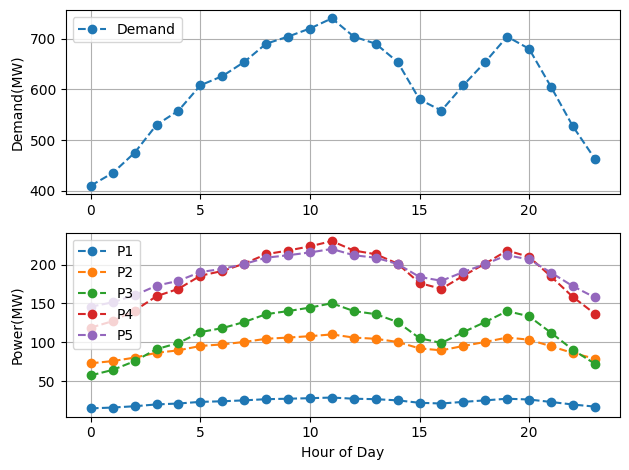

In [6]:
fig, axs = plt.subplots(2, 1)
for i in range(len(model.g)):
    axs[1].plot([value(model.P[i+1,j]) for j in range(1,25)], "--o", label=f"P{i+1}")
    
axs[0].plot([value(model.L[j]) for j in range(1,25)], "--o", label="Demand")
axs[0].grid(True), axs[1].grid(True)
axs[1].legend(), axs[0].legend()
axs[1].set_xlabel("Hour of Day")
axs[0].set_ylabel("Demand(MW)")
axs[1].set_ylabel("Power(MW)")

fig.tight_layout()
plt.show()

In [7]:
results_history = pd.DataFrame()
results_history["demand"] = [value(model.L[j]) for j in range(1,25)]
for g in range(len(model.g)):
    results_history[f"P{g+1}_nonlinear"] = [value(model.P[g+1,j]) for j in range(1,25)]
results_history["cost_nonlinear"] = [sum(value(model.c[g])*value(model.P[g,t])**2 + value(model.b[g])*value(model.P[g,t]) + \
                                     value(model.a[g]) for g in model.g) for t in range(1,25)]
results_history.head()

,demand,P1_nonlinear,P2_nonlinear,P3_nonlinear,P4_nonlinear,P5_nonlinear,cost_nonlinear
0,410,14.859155,72.957746,57.394365,118.873238,145.915492,1194.720413
1,435,15.915493,75.774647,64.436619,127.323942,151.549295,1250.875342
2,475,17.605634,80.281690,75.704224,140.845069,160.563379,1341.602102
3,530,19.929577,86.478873,91.197182,159.436618,172.957745,1468.117593
4,558,21.112676,89.633802,99.084505,168.901407,179.267604,1533.311057


**Ramp Up/Down Sensitivity:**<br>
We can change the values of $RU_{g}$ and $RD_{g}$ to see how they affect total cost and emissions. We can consider a range of values for ramp rate and solve the problem accordingly. For each generator, we can apply a ramp scale, strating from 58% of its original value, up to 100% of its original value and observe the results [1]:

In [8]:
ramp_sensitivity_df = pd.DataFrame(columns=["Ramp Scale", "Total Cost ($)", "Total Emission (kg)"])
for i in range(58,100,1):
    for g in range(len(model.g)):
        model.RU[g+1] = (ded_df.loc[g,"$RU_{g}$"]) * i / 100
        model.RD[g+1] = (ded_df.loc[g,"$RD_{g}$"]) * i / 100
    results = opt.solve(model)
    ramp_sensitivity_df.loc[(100-i)/2, "Ramp Scale"] = i/100
    ramp_sensitivity_df.loc[(100-i)/2, "Total Cost ($)"] = value(model.objective)
    ramp_sensitivity_df.loc[(100-i)/2, "Total Emission (kg)"] = value(model.GHG)

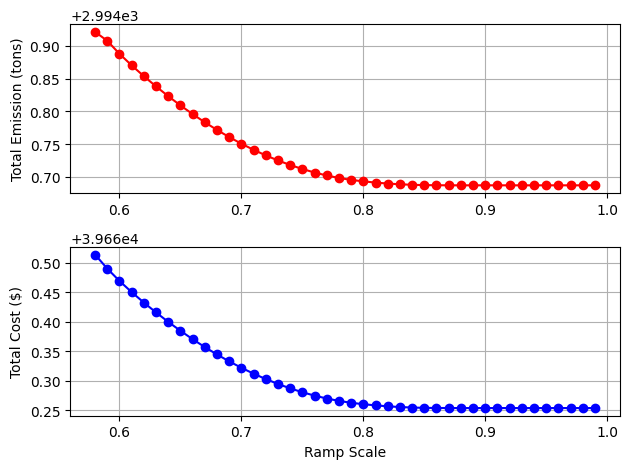

In [9]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(ramp_sensitivity_df["Ramp Scale"], ramp_sensitivity_df["Total Emission (kg)"]/1000, "r-o")   
axs[1].plot(ramp_sensitivity_df["Ramp Scale"], ramp_sensitivity_df["Total Cost ($)"], "b-o")

axs[0].grid(True), axs[1].grid(True)
axs[1].set_xlabel("Ramp Scale")
axs[0].set_ylabel("Total Emission (tons)")
axs[1].set_ylabel("Total Cost ($)")

fig.tight_layout()
plt.show()

# 1.1. Emission constrained DED
So far we only considered total cost of power generation in the optimization process. In the following section, we also add emission considerations, and produce a Pareto optimal front. To do so we need to add another constraint for the amount of emissions, as follows [1]:<br>
$$
GHG = \sum_{g,t}^{} d_{g}+ e_{g}P_{g,t} + f_{g} P_{g,t}^{2}  \le \epsilon
$$
where $\epsilon$ is the maximum allowable emissions. In order to look at the effect of emissions on optimal cost, we can very the value of $\epsilon$ between $EM^{min}$ and $EM^{max}$, and create a Pareto front. So the oprimization problem can now be represented as the following [1]:<br>
**Mathematical representation:**<br>
$$
\underset{P_{g,t}}{min} \; \sum_{g,t}^{} a_{g} + b_{g}P_{g,t} + c_{g} P_{g,t}^{2}
$$
$$
GHG \le \epsilon
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
\sum_{g}^{} P_{g,t} \ge L_{t}
$$

In the Pyomo model, we need to activate the emissions limit constraint, and change the limit value to prduce a Pareto front.

In [10]:
#Upper limit for total emission, initialized to a very large number
model.e_limit = Param(initialize=1e12, within=NonNegativeReals, mutable=True)

def total_emission_limit(model):
    return model.GHG <= model.e_limit
model.c_total_emission_limit = Constraint(rule=total_emission_limit)
###############################################################################################################
emission_cost_df = pd.DataFrame(columns=["Epsilon", "Total Cost ($)", "Total Emission (kg)"])

counter = 0
for ep in range(int(3.0e6), int(2.5e6), -int(1e4)):
    model.e_limit = ep
    
    results = opt.solve(model)
    emission_cost_df.loc[counter, "Epsilon"] = ep
    emission_cost_df.loc[counter, "Total Cost ($)"] = value(model.objective)
    emission_cost_df.loc[counter, "Total Emission (kg)"] = value(model.GHG)
    counter += 1

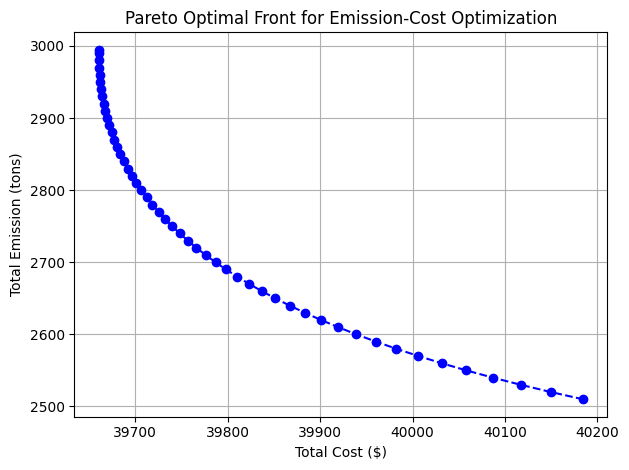

In [11]:
fig, axs = plt.subplots(1, 1)

axs.plot(emission_cost_df["Total Cost ($)"], emission_cost_df["Total Emission (kg)"]/1000, "b--o")
axs.grid(True)
axs.set_xlabel("Total Cost ($)")
axs.set_ylabel("Total Emission (tons)")
axs.set_title("Pareto Optimal Front for Emission-Cost Optimization")

fig.tight_layout()
plt.show()

# Optimal solution on the Pareto front
To find the optimal solution with respect to both total emission and cost, we can look at the solutions that fall on the Pareto optimal fron and use a fuzzy satisfying method. A linear membership function can be defined as follows [1]:
$$
\mu^{f_{k}(X_{c})} =
    \begin{cases}
      0 & \text{otherwise}\\
      \frac{f_{k}^{max} - f_{k}(X_{c})}{f_{k}^{max} - f_{k}^{min}} & f_{k}^{min} \le f_{k}(X_{c}) \le f_{k}^{max}\\
    \end{cases}
$$
<br>
$$
F_{z}(X_{c}) = \underset{}{min} \; \mu^{f_{k}(X_{c})} \;\;\;\;\;\;\;\; \forall k
$$
where $X_{c}$ are the points on the Pareto optimal front, and $f_{k}$ are each of the functions upon which the Pareto optimal fron is formed. In the case of this problem for ecxample, $f_{1} = Total \; Cost$ and $f_{2} = Total \; Emission$. Using this formulation, we can calculate the membership functions as follows:

In [12]:
emission_cost_df["$\mu_{TC}$"] = (emission_cost_df["Total Cost ($)"].max() - emission_cost_df["Total Cost ($)"]) / \
    (emission_cost_df["Total Cost ($)"].max() - emission_cost_df["Total Cost ($)"].min())
emission_cost_df["$\mu_{EM}$"] = (emission_cost_df["Total Emission (kg)"].max() - emission_cost_df["Total Emission (kg)"]) / \
    (emission_cost_df["Total Emission (kg)"].max() - emission_cost_df["Total Emission (kg)"].min())

emission_cost_df["$F_{z}$"] = emission_cost_df[["$\mu_{TC}$","$\mu_{EM}$"]].min(axis=1)

emission_cost_df.head()

,Epsilon,Total Cost ($),Total Emission (kg),$\mu_{TC}$,$\mu_{EM}$,$F_{z}$
0,3000000,39660.253512,2994686.933975,1.0,0.0,0.0
1,2990000,39660.273834,2989999.999806,0.999961,0.00967,0.00967
2,2980000,39660.455648,2980000.00001,0.999614,0.030302,0.030302
3,2970000,39660.832129,2970000.000048,0.998896,0.050934,0.050934
4,2960000,39661.411058,2960000.000063,0.997791,0.071566,0.071566


Based on this method, the optimal solution on the Pareto optimal front can be found where $F_{z}$ is maximized. Therefore:

In [13]:
print("The optimal total cost is $", round(emission_cost_df.loc[np.argmax(emission_cost_df["$F_{z}$"]), "Total Cost ($)"]))
print("The optimal total emission is ", round(emission_cost_df.loc[np.argmax(emission_cost_df["$F_{z}$"]), "Total Emission (kg)"]), \
      "kg")

The optimal total cost is $ 39823
The optimal total emission is  2670000 kg


# 1.2. Dynamic Economic Dispatch with Wind
In the previous sections, we only considered gas generators for a DED problem. In this section we also add wind generation to the problem. If we asssume that the only cost associated with wind generation comes from curtailment costs, the total cost of generation for gas and wind can be formulated as follows [1]:
$$
Total \; Cost = \sum_{g,t}^{} a_{g} + b_{g}P_{g,t} + c_{g}P_{g,t}^{2} + \sum_{t}^{} C_{crt} * P^{wc}_{t}
$$
where $C_{crt}=50$ is the cost of wind curtailment, and $P^{wc}$ is the amount of wind power that is curtailed. Considering $\Lambda^{w}_{t}$ as the amount of available wind power and $P^{w}$ as the amount of wind power generation, the optimization problem can be formulated as follows [1]:

$$
\underset{}{min} \; \sum_{g,t}^{} a_{g} + b_{g}P_{g,t} + c_{g}P_{g,t}^{2} + \sum_{t}^{} C_{crt} * P^{wc}_{t}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
P^{w}_{t} + \sum_{g}^{} P_{g,t} \ge L_{t}
$$
$$
P^{w}_{t} + P^{wc}_{t} \le \Lambda^{w}_{t}
$$

The following table provides a timeseries data for demand, available wind power, electricity price, and resrve electricity price [1,2]. 

In [14]:
wind_load_df = pd.DataFrame()
wind_load_df["Load"] = [410, 435, 475, 530, 558, 608, 626, 654, 690, 704, 720, 740, 704, 690, 654, 580, 558, 608, 654, 704, \
           680, 605, 527, 463]
wind_load_df["Wind_Availability"] = [44.1, 48.5, 65.7, 144.9, 202.3, 317.3, 364.4, 317.3, 271, 306.9, 424.1, 398, 487.6, 521.9, \
                            541.3, 560, 486.8, 372.6, 367.4, 314.3, 316.6, 311.4, 405.4, 470.4]
wind_load_df["$\lambda^{e}$"] = [32.71, 34.72, 32.71, 32.74, 32.96, 34.93, 44.9, 52, 53.03, 47.26, 44.07, 38.63, 39.91, 39.45, \
                            41.14, 39.23, 52.12, 40.85, 41.2, 41.15, 45.76, 45.59, 45.56, 34.72]
wind_load_df["$\lambda^{r}$"] = [35.55, 30.83, 29.68, 31.73, 32.43, 33.94, 42.22, 36.53, 31.41, 36.58, 35.86, 37.58, 45.18, 42.16, \
                            48.20, 37.83, 44.13, 38.80, 38.02, 37.03, 38.37, 41.94, 43.05, 40.58]
wind_load_df.head()

,Load,Wind_Availability,$\lambda^{e}$,$\lambda^{r}$
0,410,44.1,32.71,35.55
1,435,48.5,34.72,30.83
2,475,65.7,32.71,29.68
3,530,144.9,32.74,31.73
4,558,202.3,32.96,32.43


In the existing Pyomo model, we need to add 2 new wind-related parameters, 2 new variables, 2 new wind-related constraints and a new objective function that includes wind generation costs.

In [15]:
#Parameters
def wind_avail(model, t):
    return wind_load_df["Wind_Availability"][t-1]
model.avlblty = Param(model.t, initialize=wind_avail, within=NonNegativeReals)

model.Ccrt = Param(initialize=50, within=NonNegativeReals)

#Variables
model.Pwc = Var(model.t, within=NonNegativeReals)
model.Pw = Var(model.t, within=NonNegativeReals)

#Constraints
def demand_generation_with_wind(model, g, t):
    return sum(model.P[g,t] for g in model.g) + model.Pw[t] >= model.L[t]
model.c_demand_generation_with_wind = Constraint(model.g, model.t, rule=demand_generation_with_wind)

def wind_generation_limit(model, t):
    return model.Pwc[t] + model.Pw[t] <= model.avlblty[t]
model.c_wind_generation_limit = Constraint(model.t, rule=wind_generation_limit)


# This objective function is for gas + wind generation
def rule_OF2(model):
    return sum(model.c[g]*model.P[g,t]**2 + model.b[g]*model.P[g,t] + model.a[g] for g in model.g for t in model.t) + \
            sum(model.Ccrt * model.Pwc[t] for t in model.t)
model.objective2 = Objective(rule=rule_OF2, sense=minimize)

We also need to deactivate the previous objective function, as well as the previous demand-generation constraint. Furthermore, we do not consider emission limits in this section, so we ca deactivate emissions limit constraint.

In [16]:
model.c_total_emission_limit.deactivate()
model.c_demand_generation.deactivate()
model.objective.deactivate()

model.c_demand_generation_with_wind.activate()
model.c_wind_generation_limit.activate()
model.objective2.activate()


results = opt.solve(model)

In [17]:
print("Total operating cost is $", round(value(model.objective2), 0))
print("Total emission is ", round(value(model.GHG)/1000, 0), "tons")

Total operating cost is $ 22452.0
Total emission is  792.0 tons


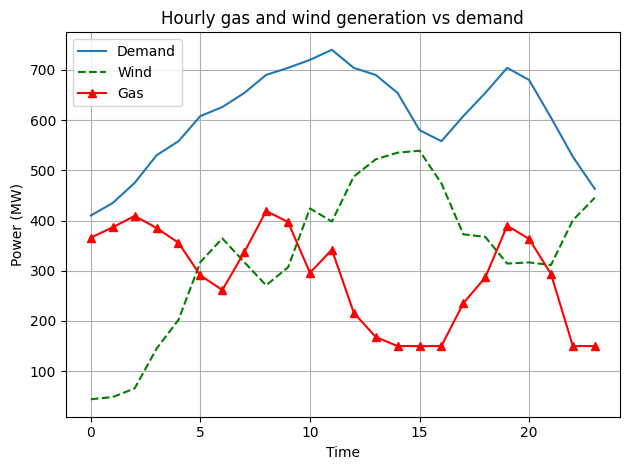

In [18]:
fig, axs = plt.subplots(1, 1)

axs.plot([value(model.L[j]) for j in range(1,25)], label="Demand")
axs.plot([value(model.Pw[j]) for j in range(1,25)], "g--", label="Wind")
axs.plot([sum(value(model.P[g,t]) for g in range(1,len(model.g)+1)) for t in range(1,25)], "r-^", label="Gas")

axs.grid(True)
axs.set_xlabel("Time")
axs.set_ylabel("Power (MW)")
axs.set_title("Hourly gas and wind generation vs demand")
axs.legend()

fig.tight_layout()
plt.show()

# 2. Price-based DED
In price-based DED, the goal is to maximize revenue from power generation, and other services. This means that the demand does not need to be met necessarily. There are two main markets through which revenue is generated: energy market, and ancillaries market. We first look into energy market alone.

# 2.1. Price-based DED in energy market only
In this section we look into price-based DED, when participating only in energy market (no arbitrage). In this case, the goal of optimization is to maximize revenue, which is defined as total income minus total costs. Therefore, revenue can be defined as follows [1]:
$$
\sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} - a_{g} - b_{g}P_{g,t} - c_{g} P_{g,t}^{2}
$$
where $\lambda^{e}_{t}$ is the price of electricity at time $t$.<br>
A major difference between price-based and cost-based DED, is in the power-demand balance. In price-based DED, we can only sell as much elecetricity as there is demand. In other words, electricity generation is limited to demand; therefore the generation-emand constraint is formulated as follows:
$$
\sum_{g,t}^{} P_{g,t} \le L_{T}
$$
The optimization problem then can be formulated as follows [1]:
$$
\underset{P_{g,t}}{max} \; \sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} - a_{g} - b_{g}P_{g,t} - c_{g} P_{g,t}^{2}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
\sum_{g}^{} P_{g,t} \le L_{t}
$$
In the existing Pyomo model, we need to add a new price-related parameter, a new price-related constraint and a new objective function that includes energy prices.

In [19]:
#Parameters
def price_e(model, t):
    return wind_load_df["$\lambda^{e}$"][t-1]
model.lmbdae = Param(model.t, initialize=price_e, within=NonNegativeReals)

#Constraints
def demand_generation_price_based(model, g, t):
    return sum(model.P[g,t] for g in model.g) <= model.L[t]
model.c_demand_generation_price_based = Constraint(model.g, model.t, rule=demand_generation_price_based)

# This objective function is for price-based DED
def rule_OF3(model):
    return  sum(model.lmbdae[t] * model.P[g,t] for g in model.g for t in model.t) - \
            sum(model.c[g]*model.P[g,t]**2 + model.b[g]*model.P[g,t] + model.a[g] for g in model.g for t in model.t)
model.objective3 = Objective(rule=rule_OF3, sense=maximize)

Since we are not considering a wind asset in this section, we should deactivate wind related constraints, and objective function, and activate the price-based objective function.

In [20]:
# Deactivate constraints for wind
model.c_demand_generation_with_wind.deactivate()
model.c_wind_generation_limit.deactivate()
model.objective2.deactivate()

# Activate constraints for price-based DED
model.c_demand_generation_price_based.activate()
model.objective3.activate()

results = opt.solve(model)

print("Total Net Revenue is $", round(value(model.objective3), 0))
print("Total operating cost is $", round(value(model.objective), 0))
print("Total emission is ", round(value(model.GHG)/1000, 0), "tons")

Total Net Revenue is $ 567261.0
Total operating cost is $ 39660.0
Total emission is  2995.0 tons


**Note:**<br>
In this section, we are only considering cost-based economic dispatch optimization for gas generators withouth emission considerations. Therefore, we disregard the constraints related to wind generation, and emissions in the above Pyomo model. This can be done as follows:

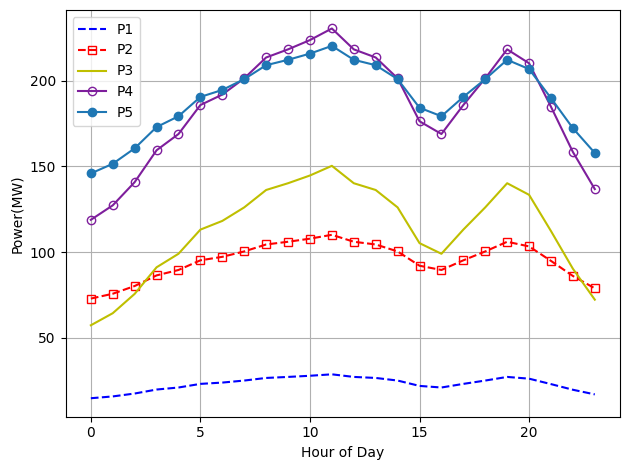

In [21]:
fig, axs = plt.subplots(1, 1)
axs.plot([value(model.P[1,j]) for j in range(1,25)], "b--", label="P1")
axs.plot([value(model.P[2,j]) for j in range(1,25)], "r--s", markerfacecolor='none', label="P2")
axs.plot([value(model.P[3,j]) for j in range(1,25)], "y-", label="P3")
axs.plot([value(model.P[4,j]) for j in range(1,25)], "-o", color="#7e1e9c", markerfacecolor='none', label="P4")
axs.plot([value(model.P[5,j]) for j in range(1,25)], "-o", label="P5")

axs.grid(True)
axs.legend()
axs.set_xlabel("Hour of Day")
axs.set_ylabel("Demand(MW)")
axs.set_ylabel("Power(MW)")

fig.tight_layout()
plt.show()

# 2.2. Price-based DED in energy plus reserve markets
If the gas generators were to also participate in the reserve market, the problem turns into a price-based DED in both energy and reserve markets. This is usually done in the day-ahead market and the prices for energy and reserves are projections with uncertainty. In this case, the gas generators can offer some their electricity generation in the reserve market, and the rest in the energy market. Denoting the electricity price by $\lambda^{e}$, spinning reserve price by $\lambda^{r}$, and the amount of energy offered in the reserve market for each gas generator by $SR_{g,t}$, the net revenue for the generators can be formulated as follows [1]:
$$
\sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} + \lambda^{r}_{t}SR_{g,t} - a_{g} - b_{g}P_{g,t} - c_{g}P_{g,t}^{2}
$$
The only additional constraint for this problem, is the fact that the sum of power generation and spinning reserve offering for each gas generator should not exceed its operating limits [1]:
$$
0 \le SR_{g,t} \le P_{g}^{max} - P_{g,t}
$$
The optimization problem then can be formulated as follows [1]:
$$
\underset{P_{g,t}}{max} \; \sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} + \lambda^{r}_{t}SR_{g,t} - a_{g} - b_{g}P_{g,t} - c_{g}P_{g,t}^{2}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
0 \le SR_{g,t} \le P_{g}^{max} - P_{g,t}
$$
$$
\sum_{g}^{} P_{g,t} \le L_{t}
$$
In the existing Pyomo model, we need to add a new price-related parameter, an new spinning reserve variable, a new spinning reserve constraint and a new objective function that includes energy prices as well as spinning reserve prices.

In [22]:
#Variables
model.SR = Var(model.g, model.t, within=NonNegativeReals)

#Parameters
def price_r(model, t):
    return wind_load_df["$\lambda^{r}$"][t-1]
model.lmbdar = Param(model.t, initialize=price_r, within=NonNegativeReals)

#Constraints
def max_reserve(model, g, t):
    return  model.SR[g,t] <= model.P_max[g] - model.P[g,t]
model.c_max_reserve = Constraint(model.g, model.t, rule=max_reserve)


# This objective function is for price-based DED with spinning reserves
def rule_OF4(model):
    return  sum(model.lmbdae[t] * model.P[g,t] + model.lmbdar[t] * model.SR[g,t] for g in model.g for t in model.t) - \
            sum(model.c[g]*model.P[g,t]**2 + model.b[g]*model.P[g,t] + model.a[g] for g in model.g for t in model.t)
model.objective4 = Objective(rule=rule_OF4, sense=maximize)

We need to deactivate the previous price-based constraint and objective function, and activate the new ones that include spinning reserve.

In [23]:
# deactivate constraints for price-based DED
model.c_demand_generation_price_based.deactivate()
model.objective3.deactivate()

# Activate constraints for price-based DED with spinning reserves
model.c_max_reserve.activate()
model.objective4.activate()


results = opt.solve(model)

print("Total net revenue is $", round(value(model.objective4), 0))
print("Total operating cost is $", round(value(model.objective), 0))
print("Total emission is ", round(value(model.GHG)/1000, 0), "tons")

Total net revenue is $ 969340.0
Total operating cost is $ 41944.0
Total emission is  3359.0 tons


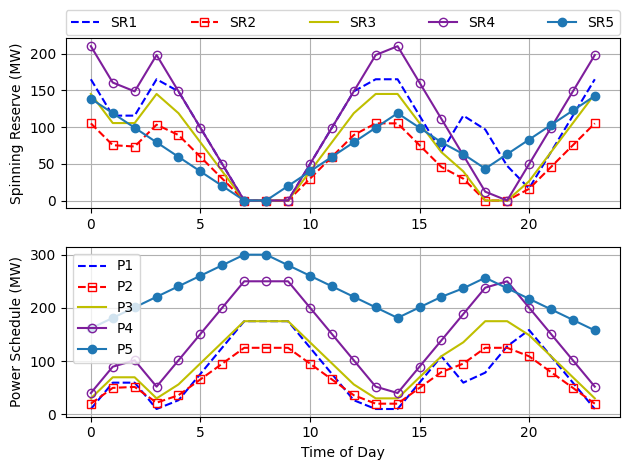

In [24]:
fig, axs = plt.subplots(2, 1)

axs[0].plot([value(model.SR[1,j]) for j in range(1,25)], "b--", label="SR1")
axs[0].plot([value(model.SR[2,j]) for j in range(1,25)], "r--s", markerfacecolor='none', label="SR2")
axs[0].plot([value(model.SR[3,j]) for j in range(1,25)], "y-", label="SR3")
axs[0].plot([value(model.SR[4,j]) for j in range(1,25)], "-o", color="#7e1e9c", markerfacecolor='none', label="SR4")
axs[0].plot([value(model.SR[5,j]) for j in range(1,25)], "-o", label="SR5")

axs[1].plot([value(model.P[1,j]) for j in range(1,25)], "b--", label="P1")
axs[1].plot([value(model.P[2,j]) for j in range(1,25)], "r--s", markerfacecolor='none', label="P2")
axs[1].plot([value(model.P[3,j]) for j in range(1,25)], "y-", label="P3")
axs[1].plot([value(model.P[4,j]) for j in range(1,25)], "-o", color="#7e1e9c", markerfacecolor='none', label="P4")
axs[1].plot([value(model.P[5,j]) for j in range(1,25)], "-o", label="P5")

axs[0].grid(True), axs[1].grid(True)
axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=5, mode="expand", borderaxespad=0.)
axs[1].legend()
axs[1].set_xlabel("Time of Day")
axs[0].set_ylabel("Spinning Reserve (MW)")
axs[1].set_ylabel("Power Schedule (MW)")

fig.tight_layout()
plt.show()

# 3. Linearizing the DED Problem
The cost of power generation from gas units, follows a quadratic function, which makes the problem a non-linear optimization problem. We can approximate this function through a series of linear functions, which in turn converts the problem into a linear optimization problem. 

To do so, we divide the interval betwen $P_{min}$ and $P_{max}$ into $n$ smaller sub-intervals. If $n$ is big enough, and these sub-intervals are small enough, the cost function can be approximated by a linear function. Using this method, and considering $n=100$ we can formulate the problem as follows [1]:
$$
\underset{P_{g,t}^{k}}{min} \; OF = \; \sum_{g,t}^{} C_{g,t}
$$

$$
0 \le P_{g,t}^{k} \le \Delta P_{g}^{k}, \;\;\; \forall k = 1:n
$$

$$
\Delta P_{g}^{k} = \frac{P_{g}^{max} - P_{g}^{min}}{n}
$$

$$
P_{g,begin}^{k} = (k-1)\Delta P_{g}^{k} + P_{g}^{min}
$$

$$
P_{g,end}^{k} = P_{g,begin}^{k} + \Delta P_{g}^{k}
$$

$$
Ptot_{g,t} = P_{g}^{min} + \sum_{k}^{} P_{g,t}^{k}
$$

$$
C_{g,t} = a_{g} + b_{g} P_{g}^{min} + c_{g} {(P_{g}^{min})}^2 + \sum_{k}^{} s_{g}^{k} P_{g,t}^{k}
$$
$$
s_{g}^{k} = \frac{C_{g,end}^{k} - C_{g,begin}^{k}}{\Delta P_{g}^{k}}
$$

$$
C_{g,begin}^{k} = a_{g} + b_{g} P_{g,begin}^{k} + c_{g} {(P_{g,begin}^{k})}^2
$$
$$
C_{g,end}^{k} = a_{g} + b_{g} P_{g,end}^{k} + c_{g} {(P_{g,end}^{k})}^2
$$

$$
Ptot_{g,t} - Ptot_{g,t-1} \le RU_{g}
$$
$$
Ptot_{g,t-1} - Ptot_{g,t} \le RD_{g}
$$

$$
\sum_{g}^{} Ptot_{g,t} \ge L_{t}
$$

In [25]:
del model

model = ConcreteModel()

#Indices
model.g = RangeSet(len(ded_df))
model.t = RangeSet(24)
model.k = RangeSet(100)

#Parameters
def cost_a(model, g):
    return ded_df.loc[g-1,"$a_{g}$"]
model.a = Param(model.g, initialize=cost_a, within=Reals)

def cost_b(model, g):
    return ded_df.loc[g-1,"$b_{g}$"]
model.b = Param(model.g, initialize=cost_b, within=Reals)

def cost_c(model, g):
    return ded_df.loc[g-1,"$c_{g}$"]
model.c = Param(model.g, initialize=cost_c, within=Reals)

def P_min_df(model, g):
    return ded_df.loc[g-1,"$P_{min}$"]
model.P_min = Param(model.g, initialize=P_min_df, within=Reals)

def P_max_df(model, g):
    return ded_df.loc[g-1,"$P_{max}$"]
model.P_max = Param(model.g, initialize=P_max_df, within=Reals)

def ramp_up(model, g):
    return ded_df.loc[g-1,"$RU_{g}$"]
model.RU = Param(model.g, initialize=ramp_up, within=Reals, mutable=True)

def ramp_down(model, g):
    return ded_df.loc[g-1,"$RD_{g}$"]
model.RD = Param(model.g, initialize=ramp_down, within=Reals, mutable=True)

def demand(model, t):
    return demands[t-1]
model.L = Param(model.t, initialize=demand, within=Reals)

def delta_p(model, g):
    return (model.P_max[g] - model.P_min[g]) / len(model.k)
model.deltap = Param(model.g, initialize=delta_p, within=NonNegativeReals)

def p_begin(model, g, k):
    return (k-1) * model.deltap[g] + model.P_min[g]
model.Pbegin = Param(model.g, model.k, initialize=p_begin, within=NonNegativeReals)

def p_end(model, g, k):
    return model.Pbegin[g,k] + model.deltap[g]
model.Pend = Param(model.g, model.k, initialize=p_end, within=NonNegativeReals)

def C_begin(model, g, k):
    return model.c[g]*model.Pbegin[g,k]**2 + model.b[g]*model.Pbegin[g,k] + model.a[g]
model.Cbegin = Param(model.g, model.k, initialize=C_begin, within=NonNegativeReals)

def C_end(model, g, k):
    return model.c[g]*model.Pend[g,k]**2 + model.b[g]*model.Pend[g,k] + model.a[g]
model.Cend = Param(model.g, model.k, initialize=C_end, within=NonNegativeReals)

def cost_gradient(model, g, k):
    return (model.Cend[g,k] - model.Cbegin[g,k]) / model.deltap[g]
model.s = Param(model.g, model.k, initialize=cost_gradient, within=NonNegativeReals)

#Variables
model.P = Var(model.g, model.t, model.k, within=NonNegativeReals)
model.Ptot = Var(model.g, model.t, within=NonNegativeReals)
model.C = Var(model.g, model.t, within=NonNegativeReals)

#Constraints
def max_generation(model, g, t, k):
    return  model.P[g,t,k] <= model.deltap[g]
model.c_max_generation = Constraint(model.g, model.t, model.k, rule=max_generation)

def Pg_generation(model, g, t):
    return  model.Ptot[g,t] == model.P_min[g] + sum(model.P[g,t,k] for k in model.k)
model.c_Pg_generation = Constraint(model.g, model.t, rule=Pg_generation)

def cost_generator(model, g, t):
    return  model.C[g,t] == model.c[g] * model.P_min[g]**2 + model.b[g]*model.P_min[g] + model.a[g] + \
            sum(model.P[g,t,k]*model.s[g,k] for k in model.k)
model.c_cost_generator = Constraint(model.g, model.t, rule=cost_generator)

def ramp_up_constraint(model, g, t):
    if t==1:
        return Constraint.Skip
    else:
        return  (model.Ptot[g,t] - model.Ptot[g,t-1]) <= model.RU[g]
model.c_ramp_up = Constraint(model.g, model.t, rule=ramp_up_constraint)

def ramp_down_constraint(model, g, t):
    if t==1:
        return Constraint.Skip
    else:
        return  (model.Ptot[g,t-1] - model.Ptot[g,t]) <= model.RD[g]
model.c_ramp_down = Constraint(model.g, model.t, rule=ramp_down_constraint)

def demand_generation(model, g, t):
    return sum(model.Ptot[g,t] for g in model.g) >= model.L[t]
model.c_demand_generation = Constraint(model.g, model.t, rule=demand_generation)

#Objective Function
def rule_OF(model):
    return sum(model.C[g,t] for g in model.g for t in model.t)
model.objective = Objective(rule=rule_OF, sense=minimize)

opt = SolverFactory('ipopt')

In [26]:
results = opt.solve(model)

print("Total operating cost is $", round(value(model.objective), 0))

Total operating cost is $ 39660.0


In [27]:
for g in range(len(model.g)):
    results_history[f"P{g+1}_linear"] = [value(model.Ptot[g+1,j]) for j in range(1,25)]
results_history["cost_linear"] = [sum(value(model.C[g,t]) for g in model.g) for t in range(1,25)]
results_history.head()

,demand,P1_nonlinear,P2_nonlinear,P3_nonlinear,P4_nonlinear,P5_nonlinear,cost_nonlinear,P1_linear,P2_linear,P3_linear,P4_linear,P5_linear,cost_linear
0,410,14.859155,72.957746,57.394365,118.873238,145.915492,1194.720413,14.949999,72.699994,57.550001,119.799997,145.000005,1194.723333
1,435,15.915493,75.774647,64.436619,127.323942,151.549295,1250.875342,16.599998,75.650000,64.150076,126.100005,152.499917,1250.882713
2,475,17.605634,80.281690,75.704224,140.845069,160.563379,1341.602102,18.249999,79.850004,76.099991,140.800001,160.000001,1341.607062
3,530,19.929577,86.478873,91.197182,159.436618,172.957745,1468.117593,19.899999,86.150017,91.749975,159.700001,172.500002,1468.119287
4,558,21.112676,89.633802,99.084505,168.901407,179.267604,1533.311057,21.549999,89.300001,99.049993,168.100003,179.999999,1533.314963


# Results Comparison
The results of the linearized model is compared to the original non-linear problem in the following plots. It can be seen that there is a slight difference between the outcome of the 2 models.

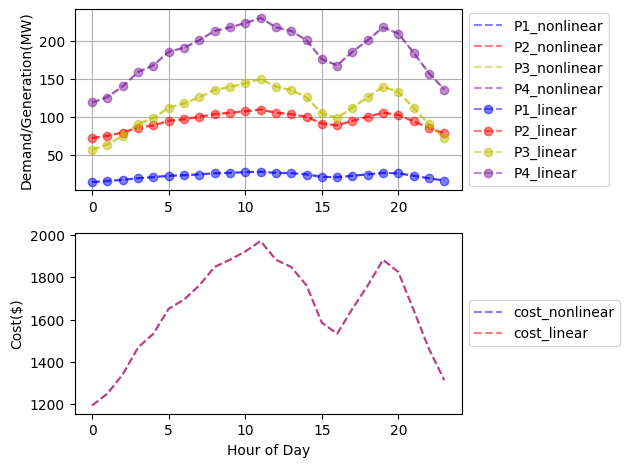

In [28]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(results_history["P1_nonlinear"], "b--", label="P1_nonlinear", alpha=0.5)
axs[0].plot(results_history["P2_nonlinear"], "r--", label="P2_nonlinear", alpha=0.5)
axs[0].plot(results_history["P3_nonlinear"], "y--", label="P3_nonlinear", alpha=0.5)
axs[0].plot(results_history["P4_nonlinear"], "--", color="#7e1e9c", label="P4_nonlinear", alpha=0.5)
axs[0].plot(results_history["P1_linear"], "b--o", label="P1_linear", alpha=0.5)
axs[0].plot(results_history["P2_linear"], "r--o", label="P2_linear", alpha=0.5)
axs[0].plot(results_history["P3_linear"], "y--o", label="P3_linear", alpha=0.5)
axs[0].plot(results_history["P4_linear"], "--o", color="#7e1e9c", label="P4_linear", alpha=0.5)

axs[1].plot(results_history["cost_nonlinear"], "b--", label="cost_nonlinear", alpha=0.5)
axs[1].plot(results_history["cost_linear"], "r--", label="cost_linear", alpha=0.5)

axs[0].grid(True)
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel("Demand/Generation(MW)")
axs[1].set_ylabel("Cost($)")
axs[1].set_xlabel("Hour of Day")

fig.tight_layout()
plt.show()

# 4. Dynamic economic dispatch with battery
**Problem Description:**<br>
The mathematical constraints to represent a DED problem with ESS would lokk like the following:
$$
\underset{P_{g,t},SOC_{t},P_{d}^{t},P_{c}^{t}}{min} \; TC = \sum_{g,t}^{} a_{g} + b_{g}P_{g,t} + c_{g}P_{g,t}^{2}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
SOC_{t} = SOC_{t-1} + (P_{t}^{c}\eta_{c} - P_{t}^{d}/\eta_{d})
$$
$$
P_{min}^{c} \le P_{t}^{c} \le P_{max}^{c}
$$
$$
P_{min}^{d} \le P_{t}^{d} \le P_{max}^{d}
$$
$$
SOC_{min} \le SOC_{t} \le SOC_{max}
$$
$$
\sum_{g}^{} P_{g,t} + P_{t}^{d} \ge L_{t} - P_{t}^{c}
$$

The following table provides the operational specifications of the battery [1]:

In [29]:
batt_df = pd.DataFrame()
batt_df["$SOC_{0}(MW)$"] = [100]
batt_df["$SOC_{max}(MW)$"] = [300]
batt_df["$SOC_{min}(MW)$"] = [60]
batt_df["$P_{max}^{d}(MW)$"] = [60]
batt_df["$P_{min}^{d}(MW)$"] = [0]
batt_df["$P_{max}^{c}(MW)$"] = [60]
batt_df["$P_{min}^{c}(MW)$"] = [0]
batt_df["$\eta_{c}$"] = [0.95]
batt_df["$\eta_{d}$"] = [0.90]
batt_df

,$SOC_{0}(MW)$,$SOC_{max}(MW)$,$SOC_{min}(MW)$,$P_{max}^{d}(MW)$,$P_{min}^{d}(MW)$,$P_{max}^{c}(MW)$,$P_{min}^{c}(MW)$,$\eta_{c}$,$\eta_{d}$
0,100,300,60,60,0,60,0,0.95,0.9


In [30]:
demands = [510, 530, 516, 510, 515, 544, 646, 686, 741, 734, 748, 760, 754, 700, 686, 720, 714, 761, 727, 714, \
           618, 584, 578, 544];

In [31]:
del model

model = ConcreteModel()

#Indices
model.g = RangeSet(len(ded_df))
model.t = RangeSet(24)

#Parameters
def cost_a(model, g):
    return ded_df.loc[g-1,"$a_{g}$"]
model.a = Param(model.g, initialize=cost_a, within=Reals)

def cost_b(model, g):
    return ded_df.loc[g-1,"$b_{g}$"]
model.b = Param(model.g, initialize=cost_b, within=Reals)

def cost_c(model, g):
    return ded_df.loc[g-1,"$c_{g}$"]
model.c = Param(model.g, initialize=cost_c, within=Reals)

def P_min_df(model, g):
    return ded_df.loc[g-1,"$P_{min}$"]
model.P_min = Param(model.g, initialize=P_min_df, within=Reals)

def P_max_df(model, g):
    return ded_df.loc[g-1,"$P_{max}$"]
model.P_max = Param(model.g, initialize=P_max_df, within=Reals)

def ramp_up(model, g):
    return ded_df.loc[g-1,"$RU_{g}$"]
model.RU = Param(model.g, initialize=ramp_up, within=Reals, mutable=True)

def ramp_down(model, g):
    return ded_df.loc[g-1,"$RD_{g}$"]
model.RD = Param(model.g, initialize=ramp_down, within=Reals, mutable=True)

def demand(model, t):
    return demands[t-1]
model.L = Param(model.t, initialize=demand, within=Reals)

def soc0_func(model):
    return batt_df.loc[0,"$SOC_{0}(MW)$"]
model.SOC0 = Param(initialize=soc0_func, within=Reals)

def socmax_func(model):
    return batt_df.loc[0,"$SOC_{max}(MW)$"]
model.SOCmax = Param(initialize=socmax_func, within=Reals)

def socmin_func(model):
    return batt_df.loc[0,"$SOC_{min}(MW)$"]
model.SOCmin = Param(initialize=socmin_func, within=Reals)

def Pdmax_func(model):
    return batt_df.loc[0,"$P_{max}^{d}(MW)$"]
model.Pdmax = Param(initialize=Pdmax_func, within=Reals)

def Pdmin_func(model):
    return batt_df.loc[0,"$P_{min}^{d}(MW)$"]
model.Pdmin = Param(initialize=Pdmin_func, within=Reals)

def Pcmax_func(model):
    return batt_df.loc[0,"$P_{max}^{c}(MW)$"]
model.Pcmax = Param(initialize=Pcmax_func, within=Reals)

def Pcmin_func(model):
    return batt_df.loc[0,"$P_{min}^{c}(MW)$"]
model.Pcmin = Param(initialize=Pcmin_func, within=Reals)

def etac_func(model):
    return batt_df.loc[0,"$\eta_{c}$"]
model.etac = Param(initialize=etac_func, within=Reals)

def etad_func(model):
    return batt_df.loc[0,"$\eta_{d}$"]
model.etad = Param(initialize=etad_func, within=Reals)


#Variables
model.P = Var(model.g, model.t, within=NonNegativeReals)
def SOC_bounds(model,t):
    return (model.SOCmin,model.SOCmax)
model.SOC = Var(model.t, bounds=SOC_bounds, within=NonNegativeReals)
def Pc_bounds(model,t):
    return (model.Pcmin,model.Pcmax)
model.Pc = Var(model.t, bounds=Pc_bounds, within=NonNegativeReals)
def Pd_bounds(model,t):
    return (model.Pdmin,model.Pdmax)
model.Pd = Var(model.t, bounds=Pd_bounds, within=NonNegativeReals)

#Constraints
def min_generation(model, g, t):
    return  model.P[g,t] >= model.P_min[g]
model.c_min_generation = Constraint(model.g, model.t, rule=min_generation)

def max_generation(model, g, t):
    return  model.P[g,t] <= model.P_max[g]
model.c_max_generation = Constraint(model.g, model.t, rule=max_generation)

def ramp_up_constraint(model, g, t):
    if t==1:
        return Constraint.Skip
    else:
        return  (model.P[g,t] - model.P[g,t-1]) <= model.RU[g]
model.c_ramp_up = Constraint(model.g, model.t, rule=ramp_up_constraint)

def ramp_down_constraint(model, g, t):
    if t==1:
        return Constraint.Skip
    else:
        return  (model.P[g,t-1] - model.P[g,t]) <= model.RD[g]
model.c_ramp_down = Constraint(model.g, model.t, rule=ramp_down_constraint)

def SOC_constraint(model, t):
    if t==1:
        return model.SOC[t] == model.SOC0 + (model.Pc[t] * model.etac) - (model.Pd[t] / model.etad)
    elif t==24:
        return model.SOC[t] == model.SOC0
    else:
        return  model.SOC[t] == model.SOC[t-1] + (model.Pc[t] * model.etac) - (model.Pd[t] / model.etad)
model.c_SOC = Constraint(model.t, rule=SOC_constraint)

def demand_generation(model, t):
    return sum(model.P[g,t] for g in model.g) + model.Pd[t] >= model.L[t] + model.Pc[t]
model.c_demand_generation = Constraint(model.t, rule=demand_generation)


#Objective Function
def rule_OF(model):
    return sum(model.c[g]*model.P[g,t]**2 + model.b[g]*model.P[g,t] + model.a[g] for g in model.g for t in model.t)
model.objective = Objective(rule=rule_OF, sense=minimize)

opt = SolverFactory('ipopt')

In [32]:
results = opt.solve(model)

print("Total operating cost is $", round(value(model.objective), 0))

Total operating cost is $ 41729.0


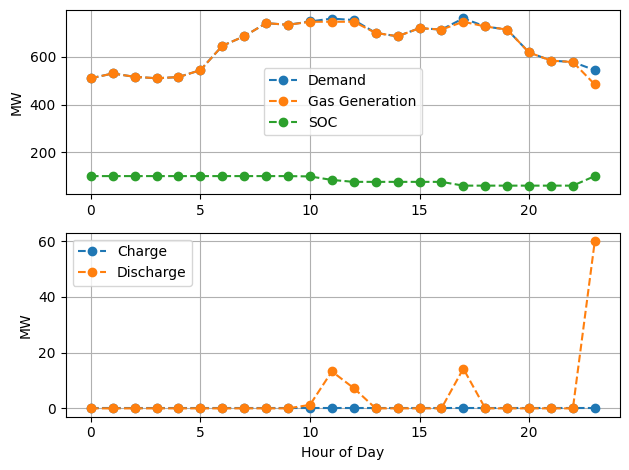

In [33]:
fig, axs = plt.subplots(2, 1)
axs[0].plot([value(model.L[j]) for j in range(1,25)], "--o", label="Demand")
axs[0].plot([sum(value(model.P[:,j])) for j in range(1,25)], "--o", label="Gas Generation")
axs[0].plot([value(model.SOC[j]) for j in range(1,25)], "--o", label="SOC")

axs[1].plot([value(model.Pc[j]) for j in range(1,25)], "--o", label="Charge")
axs[1].plot([value(model.Pd[j]) for j in range(1,25)], "--o", label="Discharge")

axs[0].grid(True), axs[1].grid(True)
axs[1].legend(), axs[0].legend()
axs[1].set_xlabel("Hour of Day")
axs[0].set_ylabel("MW")
axs[1].set_ylabel("MW")

fig.tight_layout()
plt.show()

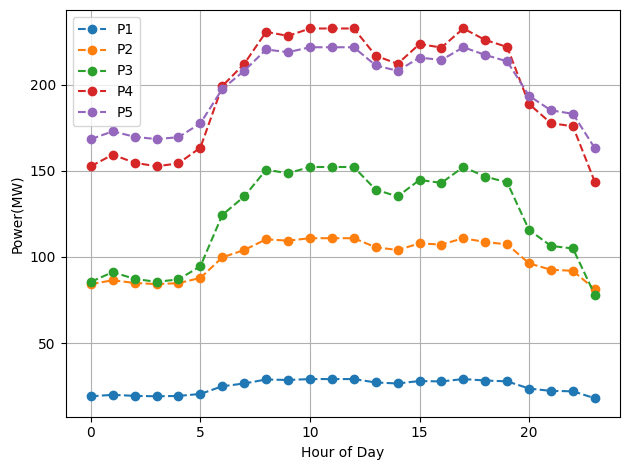

In [34]:
fig, axs = plt.subplots(1, 1)
for i in range(len(model.g)):
    axs.plot([value(model.P[i+1,j]) for j in range(1,25)], "--o", label=f"P{i+1}")
axs.grid(True)
axs.legend()
axs.set_xlabel("Hour of Day")
axs.set_ylabel("Power(MW)")

fig.tight_layout()
plt.show()

# 5. Dynamic economic dispatch with battery and wind
**Problem Description:**<br>
The mathematical constraints to represent a DED problem with ESS would lokk like the following:
$$
\underset{}{min} \; TC = \sum_{g,t}^{} a_{g} + b_{g}P_{g,t} + c_{g}P_{g,t}^{2} + \sum_{t}^{} C_{crt} * P^{wc}_{t}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
SOC_{t} = SOC_{t-1} + (P_{t}^{c}\eta_{c} - P_{t}^{d}/\eta_{d})
$$
$$
P_{min}^{c} \le P_{t}^{c} \le P_{max}^{c}
$$
$$
P_{min}^{d} \le P_{t}^{d} \le P_{max}^{d}
$$
$$
SOC_{min} \le SOC_{t} \le SOC_{max}
$$
$$
\sum_{g}^{} P_{g,t} + P_{t}^{d} + P_{t}^{w} \ge L_{t} - P_{t}^{c}
$$
$$
P_{t}^{w} + P_{t}^{wc} \le \Lambda_{t}^{w}
$$

In [35]:
avlblty = [44.1, 48.5, 65.7, 144.9, 202.3, 317.3, 364.4, 317.3, 271, 306.9, 424.1, 398, 487.6, 521.9, \
                            541.3, 560, 486.8, 372.6, 367.4, 314.3, 316.6, 311.4, 405.4, 470.4]

In [36]:
#Parameters
def wind_avail(model, t):
    return avlblty[t-1]
model.avlblty = Param(model.t, initialize=wind_avail, within=NonNegativeReals)

model.Ccrt = Param(initialize=50, within=NonNegativeReals)

#Variables
model.Pwc = Var(model.t, within=NonNegativeReals)
model.Pw = Var(model.t, within=NonNegativeReals)

#Constraints
def demand_generation_with_wind(model, g, t):
    return sum(model.P[g,t] for g in model.g) + model.Pd[t] + model.Pw[t] >= model.L[t] + model.Pc[t]
model.c_demand_generation_with_wind = Constraint(model.g, model.t, rule=demand_generation_with_wind)

def wind_generation_limit(model, t):
    return model.Pwc[t] + model.Pw[t] <= model.avlblty[t]
model.c_wind_generation_limit = Constraint(model.t, rule=wind_generation_limit)


# This objective function is for gas + wind generation
def rule_OF2(model):
    return sum(model.c[g]*model.P[g,t]**2 + model.b[g]*model.P[g,t] + model.a[g] for g in model.g for t in model.t) + \
            sum(model.Ccrt * model.Pwc[t] for t in model.t)
model.objective2 = Objective(rule=rule_OF2, sense=minimize)

In [37]:
model.c_demand_generation.deactivate()
model.objective.deactivate()

model.c_demand_generation_with_wind.activate()
model.c_wind_generation_limit.activate()
model.objective2.activate()


results = opt.solve(model)

In [38]:
results = opt.solve(model)

print("Total operating cost is $", round(value(model.objective2), 0))

Total operating cost is $ 23683.0


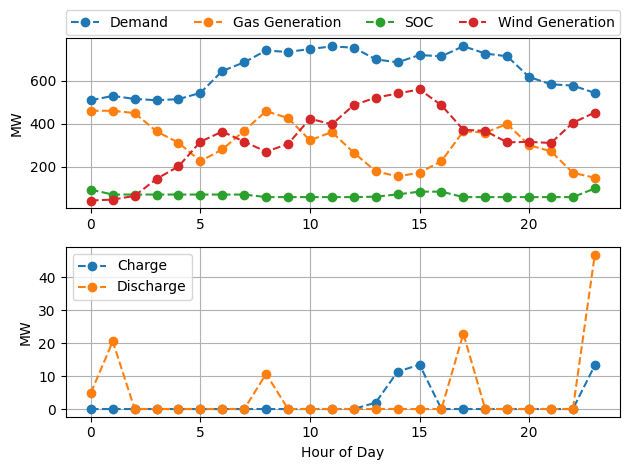

In [39]:
fig, axs = plt.subplots(2, 1)
axs[0].plot([value(model.L[j]) for j in range(1,25)], "--o", label="Demand")
axs[0].plot([sum(value(model.P[:,j])) for j in range(1,25)], "--o", label="Gas Generation")
axs[0].plot([value(model.SOC[j]) for j in range(1,25)], "--o", label="SOC")
axs[0].plot([value(model.Pw[j]) for j in range(1,25)], "--o", label="Wind Generation")

axs[1].plot([value(model.Pc[j]) for j in range(1,25)], "--o", label="Charge")
axs[1].plot([value(model.Pd[j]) for j in range(1,25)], "--o", label="Discharge")

axs[0].grid(True), axs[1].grid(True)
axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=4, mode="expand", borderaxespad=0.)
axs[1].legend()
axs[1].set_xlabel("Hour of Day")
axs[0].set_ylabel("MW")
axs[1].set_ylabel("MW")

fig.tight_layout()
plt.show()

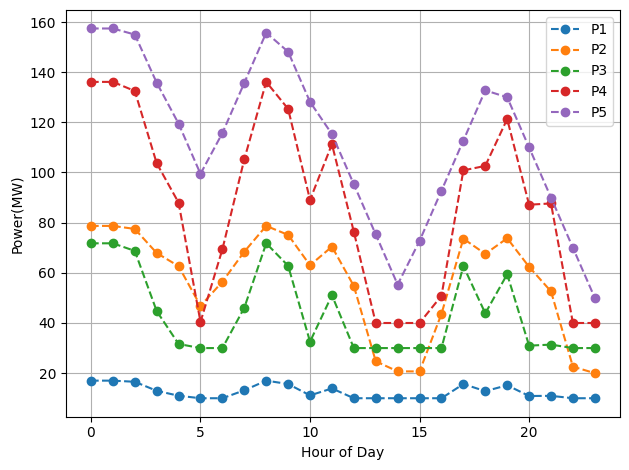

In [40]:
fig, axs = plt.subplots(1, 1)
for i in range(len(model.g)):
    axs.plot([value(model.P[i+1,j]) for j in range(1,25)], "--o", label=f"P{i+1}")
axs.grid(True)
axs.legend()
axs.set_xlabel("Hour of Day")
axs.set_ylabel("Power(MW)")

fig.tight_layout()
plt.show()

# References
1. Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.
2. Santra D, Mukherjee A, Sarker K, Mondal S. Dynamic economic dispatch using hybrid metaheuristics. Journal of Electrical Systems and Information Technology. 2020 Dec;7:1-30.
3. Nagarajan K, Rajagopalan A, Bajaj M, Sitharthan R, Dost Mohammadi SA, Blazek V. Optimizing dynamic economic dispatch through an enhanced Cheetah-inspired algorithm for integrated renewable energy and demand-side management. Scientific Reports. 2024 Feb 7;14(1):3091.